# Denoising Simulated Sensor Data

By Yaohang Li

In [1]:
from __future__ import print_function
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats

from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn import preprocessing

import tensorflow.keras
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Dense, Dropout, Flatten, Reshape, GlobalAveragePooling1D
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Conv1D, MaxPooling1D, AveragePooling1D, UpSampling1D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import utils

In [2]:
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

### Supporting Subroutines

In [3]:
def feature_normalize(dataset):

    mu = np.mean(dataset, axis=0)
    sigma = np.std(dataset, axis=0)
    return (dataset - mu)/sigma


def show_confusion_matrix(validations, predictions):

    matrix = metrics.confusion_matrix(validations, predictions)
    plt.figure(figsize=(6, 4))
    sns.heatmap(matrix,
                cmap="coolwarm",
                linecolor='white',
                linewidths=1,
                xticklabels=LABELS,
                yticklabels=LABELS,
                annot=True,
                fmt="d")
    plt.title("Confusion Matrix")
    plt.ylabel("True Label")
    plt.xlabel("Predicted Label")
    plt.show()


def show_basic_dataframe_info(dataframe,
                              preview_rows=20):

    """
    This function shows basic information for the given dataframe
    Args:
        dataframe: A Pandas DataFrame expected to contain data
        preview_rows: An integer value of how many rows to preview
    Returns:
        Nothing
    """

    # Shape and how many rows and columns
    print("Number of columns in the dataframe: %i" % (dataframe.shape[1]))
    print("Number of rows in the dataframe: %i\n" % (dataframe.shape[0]))
    print("First 20 rows of the dataframe:\n")
    # Show first 20 rows
    print(dataframe.head(preview_rows))
    print("\nDescription of dataframe:\n")
    # Describe dataset like mean, min, max, etc.
    # print(dataframe.describe())


def read_data(file_path):

    """
    This function reads the accelerometer data from a file
    Args:
        file_path: URL pointing to the CSV file
    Returns:
        A pandas dataframe
    """

    column_names = ['user-id',
                    'activity',
                    'timestamp',
                    'x-axis',
                    'y-axis',
                    'z-axis']
    df = pd.read_csv(file_path,
                     header=None,
                     names=column_names)
    # Last column has a ";" character which must be removed ...
    df['z-axis'].replace(regex=True,
      inplace=True,
      to_replace=r';',
      value=r'')
    # ... and then this column must be transformed to float explicitly
    df['z-axis'] = df['z-axis'].apply(convert_to_float)
    # This is very important otherwise the model will not fit and loss
    # will show up as NAN
    df.dropna(axis=0, how='any', inplace=True)

    return df


def convert_to_float(x):

    try:
        return np.float(x)
    except:
        return np.nan


# Not used right now
def feature_normalize(dataset):

    mu = np.mean(dataset, axis=0)
    sigma = np.std(dataset, axis=0)
    return (dataset - mu)/sigma


def plot_axis(ax, x, y, title):

    ax.plot(x, y)
    ax.set_title(title)
    ax.xaxis.set_visible(False)
    ax.set_ylim([min(y) - np.std(y), max(y) + np.std(y)])
    ax.set_xlim([min(x), max(x)])
    ax.grid(True)


def plot_activity(activity, data):

    fig, (ax0, ax1, ax2) = plt.subplots(nrows=3,
         figsize=(15, 10),
         sharex=True)
    plot_axis(ax0, data['timestamp'], data['x-axis'], 'x-axis')
    plot_axis(ax1, data['timestamp'], data['y-axis'], 'y-axis')
    plot_axis(ax2, data['timestamp'], data['z-axis'], 'z-axis')
    plt.subplots_adjust(hspace=0.2)
    fig.suptitle(activity)
    plt.subplots_adjust(top=0.90)
    plt.show()


def create_segments_and_labels(df, time_steps, step, label_name):

    """
    This function receives a dataframe and returns the reshaped segments
    of x,y,z acceleration as well as the corresponding labels
    Args:
        df: Dataframe in the expected format
        time_steps: Integer value of the length of a segment that is created
    Returns:
        reshaped_segments
        labels:
    """

    # x, y, z acceleration as features
    N_FEATURES = 3
    # Number of steps to advance in each iteration (for me, it should always
    # be equal to the time_steps in order to have no overlap between segments)
    # step = time_steps
    segments = []
    labels = []
    for i in range(0, len(df) - time_steps, step):
        xs = df['x-axis'].values[i: i + time_steps]
        ys = df['y-axis'].values[i: i + time_steps]
        zs = df['z-axis'].values[i: i + time_steps]
        # Retrieve the most often used label in this segment
        label = stats.mode(df[label_name][i: i + time_steps])[0][0]
        segments.append([xs, ys, zs])
        labels.append(label)

    # Bring the segments into a better shape
    reshaped_segments = np.asarray(segments, dtype= np.float32).reshape(-1, time_steps, N_FEATURES)
    labels = np.asarray(labels)

    return reshaped_segments, labels

# %%

In [4]:
pd.options.display.float_format = '{:.1f}'.format
sns.set() # Default seaborn look and feel
plt.style.use('ggplot')
print('keras version ', tensorflow.keras.__version__)

LABELS = ["Downstairs",
          "Jogging",
          "Sitting",
          "Standing",
          "Upstairs",
          "Walking"]
# The number of steps within one time segment
TIME_PERIODS = 80
# The steps to take from one segment to the next; if this value is equal to
# TIME_PERIODS, then there is no overlap between the segments
STEP_DISTANCE = 40

keras version  2.2.4-tf


### Load Data

In [5]:
print("\n--- Load, inspect and transform data ---\n")

# Load data set containing all the data from csv
df = read_data('Data/WISDM_ar_v1.1_raw.txt')


--- Load, inspect and transform data ---



### Inspect Data

In [6]:
# Describe the data
show_basic_dataframe_info(df, 20)

Number of columns in the dataframe: 6
Number of rows in the dataframe: 1098203

First 20 rows of the dataframe:

    user-id activity       timestamp  x-axis  y-axis  z-axis
0        33  Jogging  49105962326000    -0.7    12.7     0.5
1        33  Jogging  49106062271000     5.0    11.3     1.0
2        33  Jogging  49106112167000     4.9    10.9    -0.1
3        33  Jogging  49106222305000    -0.6    18.5     3.0
4        33  Jogging  49106332290000    -1.2    12.1     7.2
5        33  Jogging  49106442306000     1.4    -2.5    -6.5
6        33  Jogging  49106542312000    -0.6    10.6     5.7
7        33  Jogging  49106652389000    -0.5    13.9     7.1
8        33  Jogging  49106762313000    -8.4    11.4     5.1
9        33  Jogging  49106872299000     1.0     1.4     1.6
10       33  Jogging  49106982315000    -8.2    19.6     2.7
11       33  Jogging  49107092330000     1.4     5.8     3.0
12       33  Jogging  49107202316000    -1.9    -3.0    -0.3
13       33  Jogging  49107312332

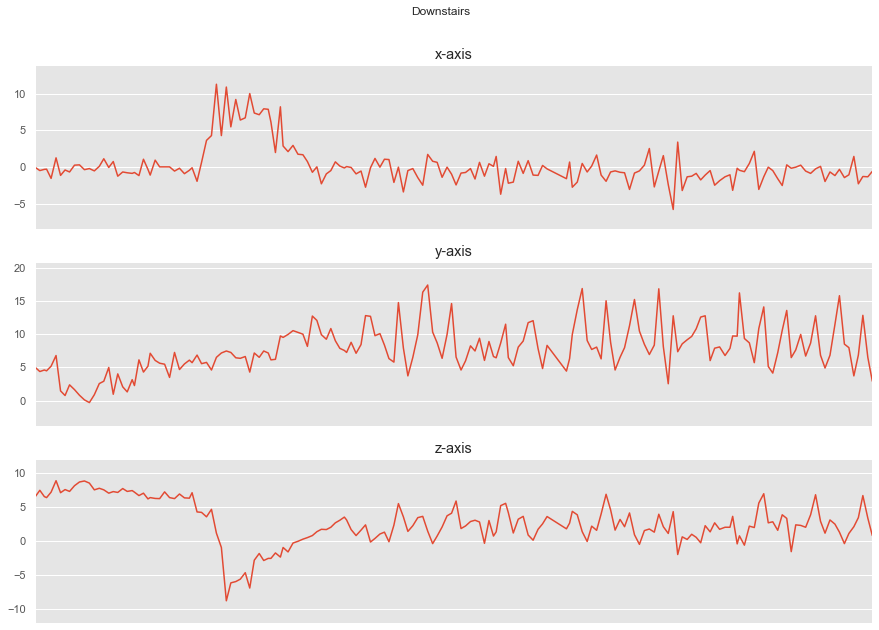

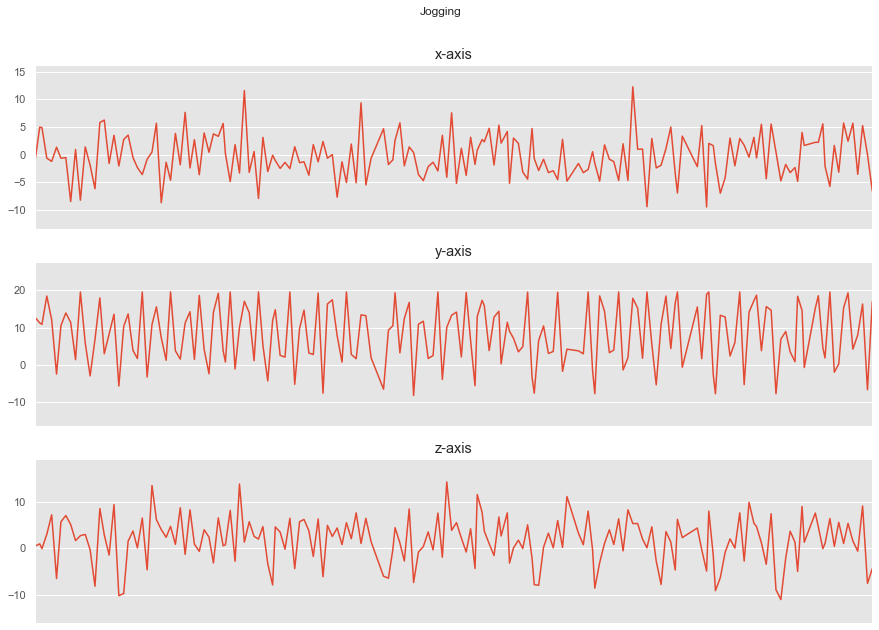

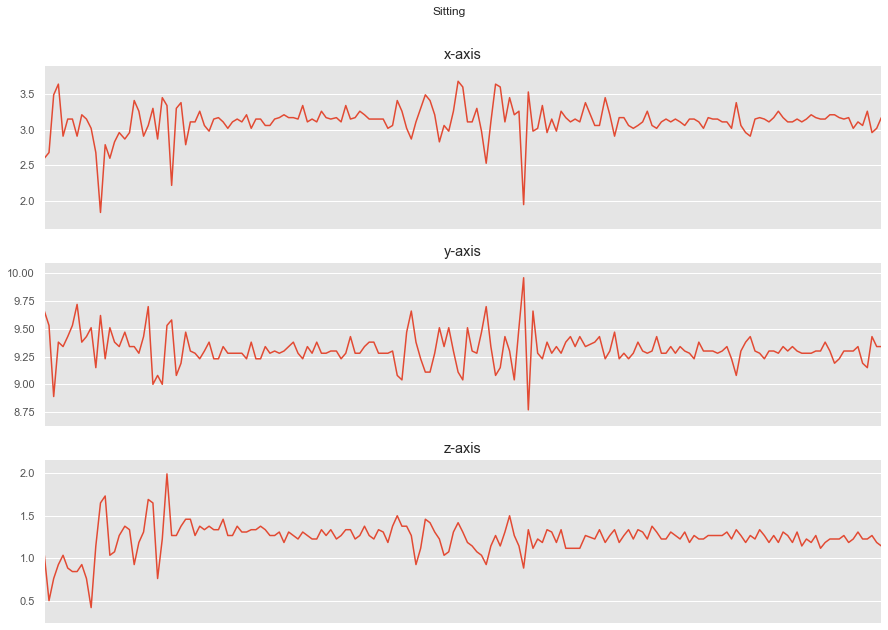

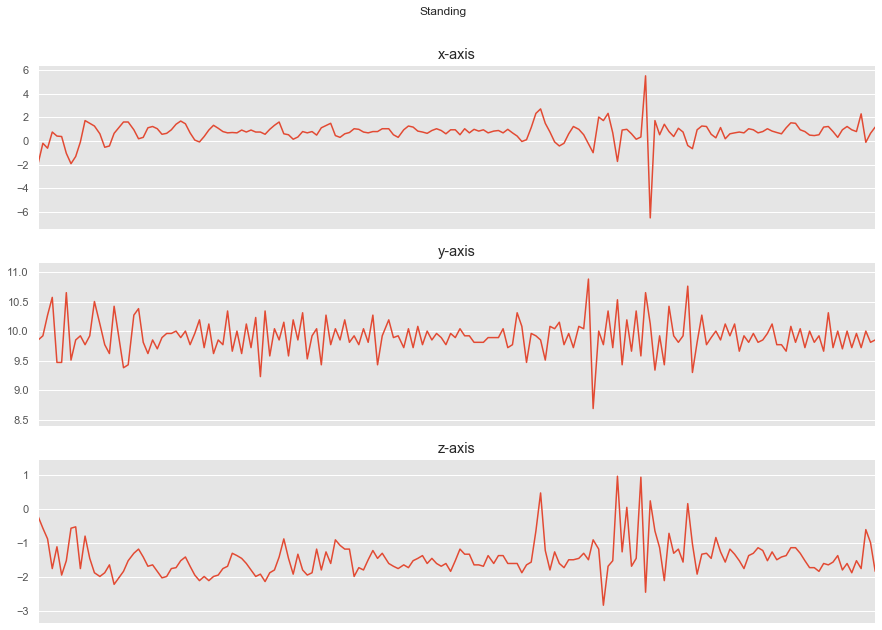

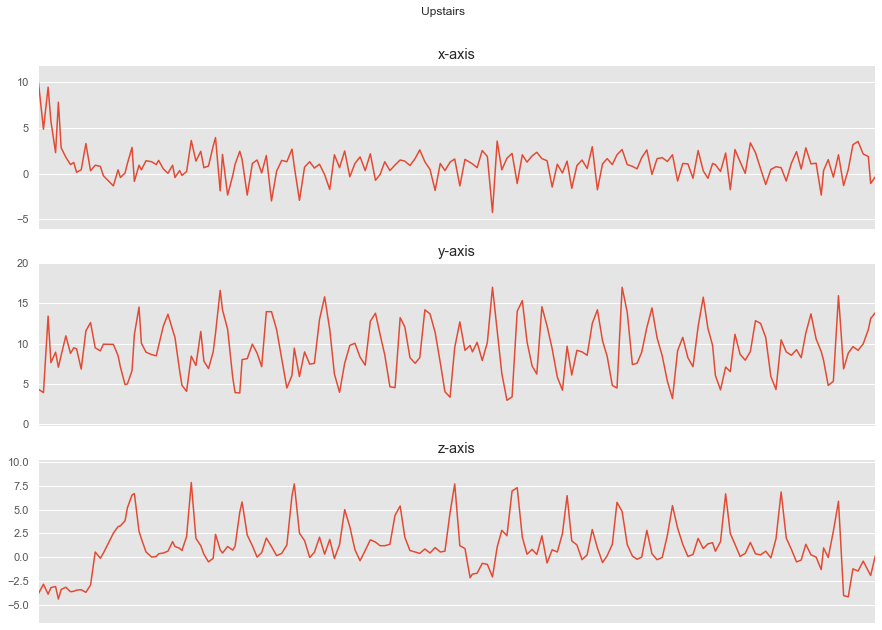

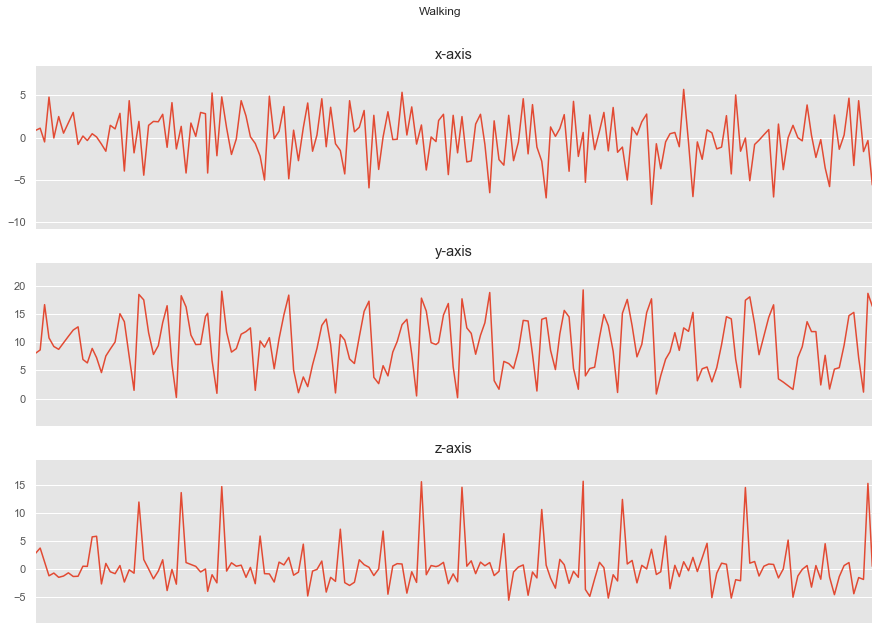

In [7]:
for activity in np.unique(df["activity"]):
    subset = df[df["activity"] == activity][:180]
    plot_activity(activity, subset)

# Define column name of the label vector
LABEL = "ActivityEncoded"
# Transform the labels from String to Integer via LabelEncoder
le = preprocessing.LabelEncoder()
# Add a new column to the existing DataFrame with the encoded values
df[LABEL] = le.fit_transform(df["activity"].values.ravel())

### Prepare training data

In [8]:
print("\n--- Reshape the data into segments ---\n")

# Differentiate between test set and training set
df_test = df[df['user-id'] > 28]
df_train = df[df['user-id'] <= 28]

# Normalize features for training data set
df_train['x-axis'] = feature_normalize(df['x-axis'])
xmu = np.mean(df_train['x-axis'], axis=0)
xsigma = np.std(df_train['x-axis'], axis=0)
df_train['y-axis'] = feature_normalize(df['y-axis'])
ymu = np.mean(df_train['y-axis'], axis=0)
ysigma = np.std(df_train['y-axis'], axis=0)
df_train['z-axis'] = feature_normalize(df['z-axis'])
zmu = np.mean(df_train['z-axis'], axis=0)
zsigma = np.std(df_train['z-axis'], axis=0)

# Round in order to comply to NSNumber from iOS
df_train = df_train.round({'x-axis': 6, 'y-axis': 6, 'z-axis': 6})

# Reshape the training data into segments
# so that they can be processed by the network
x_train, y_train = create_segments_and_labels(df_train,
                                              TIME_PERIODS,
                                              STEP_DISTANCE,
                                              LABEL)


--- Reshape the data into segments ---



D:\ProgramData\Anaconda3\envs\tfgpu\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
D:\ProgramData\Anaconda3\envs\tfgpu\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
D:\ProgramData\Anaconda3\envs\tfgpu\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_i

### Simulate 10 highly correlated sensors

In [9]:
x_train_new = x_train
for _ in range(9):
    x_train_variate = x_train + np.random.randn(x_train.shape[0], x_train.shape[1], x_train.shape[2])*0.01
    x_train_new = np.concatenate((x_train_new, x_train_variate), axis=2)
x_train = x_train_new

### Generate the noisy input

In [10]:
x_train_noise = x_train + np.random.randn(x_train.shape[0], x_train.shape[1], x_train.shape[2])*0.5

### Denoise auto encoder architecture

In [11]:
input_sig = Input(shape=(80, 30))
flat = Flatten()(input_sig)
# x = Dense(1000, activation='relu')(flat)
# x = Dropout(0.05)(x)
# x = Dense(210, activation='relu')(x)
# x = Dropout(0.1)(x)
x = Dense(240)(flat)
# x = Dropout(0.1)(x)
# x = Dense(1000, activation='relu')(x)
# x = Dropout(0.05)(x)
# x = Dense(220, activation='relu')(x)
# x = Dropout(0.1)(x)
x = Dense(2400)(x)
decoded = Reshape((80, 30))(x)
model= Model(input_sig, decoded)
model.compile(optimizer = Adam(0.0001, beta_1=0.5), loss = "mse")
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 80, 30)]          0         
_________________________________________________________________
flatten (Flatten)            (None, 2400)              0         
_________________________________________________________________
dense (Dense)                (None, 240)               576240    
_________________________________________________________________
dense_1 (Dense)              (None, 2400)              578400    
_________________________________________________________________
reshape (Reshape)            (None, 80, 30)            0         
Total params: 1,154,640
Trainable params: 1,154,640
Non-trainable params: 0
_________________________________________________________________


In [12]:
# input_sig = Input(shape=(80,3))

# x = Conv1D(100,10, activation='relu', padding='same',dilation_rate=2)(input_sig)
# x1 = MaxPooling1D(2)(x)
# x2 = Conv1D(100,10, activation='relu', padding='same',dilation_rate=2)(x1)
# x3 = MaxPooling1D(2)(x2)
# x4 = AveragePooling1D()(x3)
# flat = Flatten()(x4)
# encoded = Dense(160)(flat)
# d1 = Dense(20)(encoded)
# d2 = Reshape((20, 1))(d1)
# d3 = Conv1D(100,1,strides=1, activation='relu', padding='same')(d2)
# d4 = UpSampling1D(2)(d3)
# d5 = Conv1D(1,1,strides=1, activation='relu', padding='same')(d4)
# d6 = UpSampling1D(2)(d5)
# # d7 = UpSampling1D(2)(d6)
# decoded = Conv1D(3,1,strides=1, padding='same')(d6)
# model= Model(input_sig, decoded)
# model.compile(optimizer = Adam(0.001, beta_1=0.5), loss = "mse")
# model.summary()

### Training

In [13]:
model.fit(x_train_noise, x_train, batch_size=64, epochs=50, validation_split=0.2, verbose=1)

Train on 16694 samples, validate on 4174 samples
Epoch 1/50
16694/16694 [==============================] - 2s 99us/sample - loss: 0.8106 - val_loss: 0.6051
Epoch 2/50
16694/16694 [==============================] - 1s 62us/sample - loss: 0.4813 - val_loss: 0.4411
Epoch 3/50
16694/16694 [==============================] - 1s 61us/sample - loss: 0.3618 - val_loss: 0.3546
Epoch 4/50
16694/16694 [==============================] - 1s 62us/sample - loss: 0.2876 - val_loss: 0.2886
Epoch 5/50
16694/16694 [==============================] - 1s 62us/sample - loss: 0.2313 - val_loss: 0.2354
Epoch 6/50
16694/16694 [==============================] - 1s 63us/sample - loss: 0.1877 - val_loss: 0.1928
Epoch 7/50
16694/16694 [==============================] - 1s 63us/sample - loss: 0.1540 - val_loss: 0.1593
Epoch 8/50
16694/16694 [==============================] - 1s 62us/sample - loss: 0.1283 - val_loss: 0.1336
Epoch 9/50
16694/16694 [==============================] - 1s 60us/sample - loss: 0.1086 - val_l

### Inspect it on the test data

In [14]:
# Normalize features for training data set
df_test['x-axis'] = feature_normalize(df_test['x-axis'])
df_test['y-axis'] = feature_normalize(df_test['y-axis'])
df_test['z-axis'] = feature_normalize(df_test['z-axis'])

df_test = df_test.round({'x-axis': 6, 'y-axis': 6, 'z-axis': 6})

x_test, y_test = create_segments_and_labels(df_test,
                                            TIME_PERIODS,
                                            STEP_DISTANCE,
                                            LABEL)

D:\ProgramData\Anaconda3\envs\tfgpu\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
D:\ProgramData\Anaconda3\envs\tfgpu\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
D:\ProgramData\Anaconda3\envs\tfgpu\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using 

In [15]:
x_test_new = x_test
for _ in range(9):
    x_test_variate = x_test + np.random.randn(x_test.shape[0], x_test.shape[1], x_test.shape[2])*0.01
    x_test_new = np.concatenate((x_test_new, x_test_variate), axis=2)
x_test = x_test_new

In [16]:
x_test_noise = x_test + np.random.randn(x_test.shape[0], x_test.shape[1], x_test.shape[2])*0.5

In [17]:
x_pred = model.predict(x_test_noise)

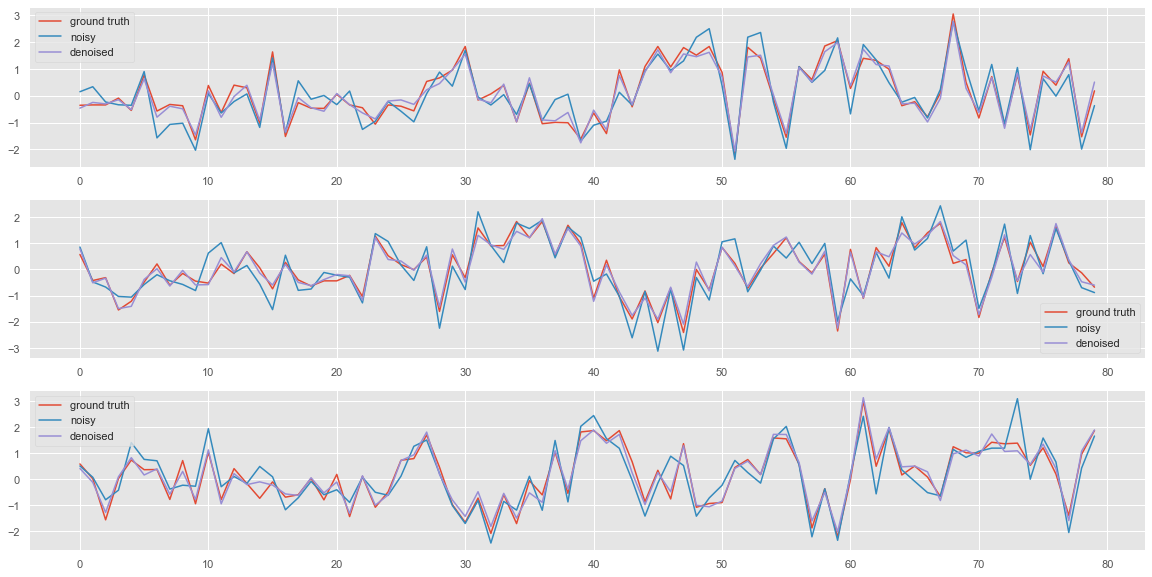

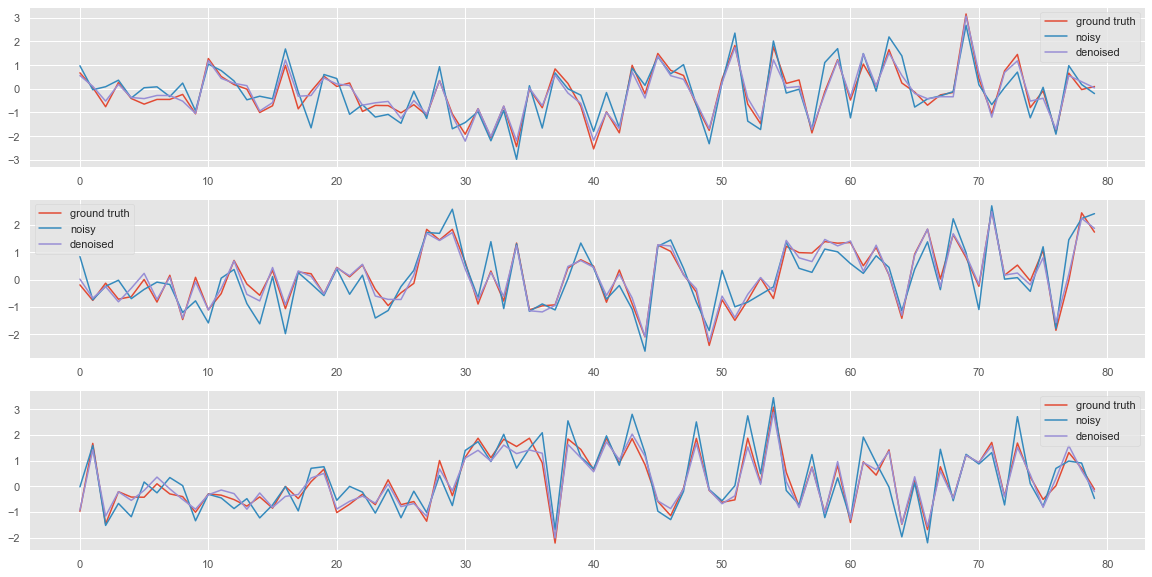

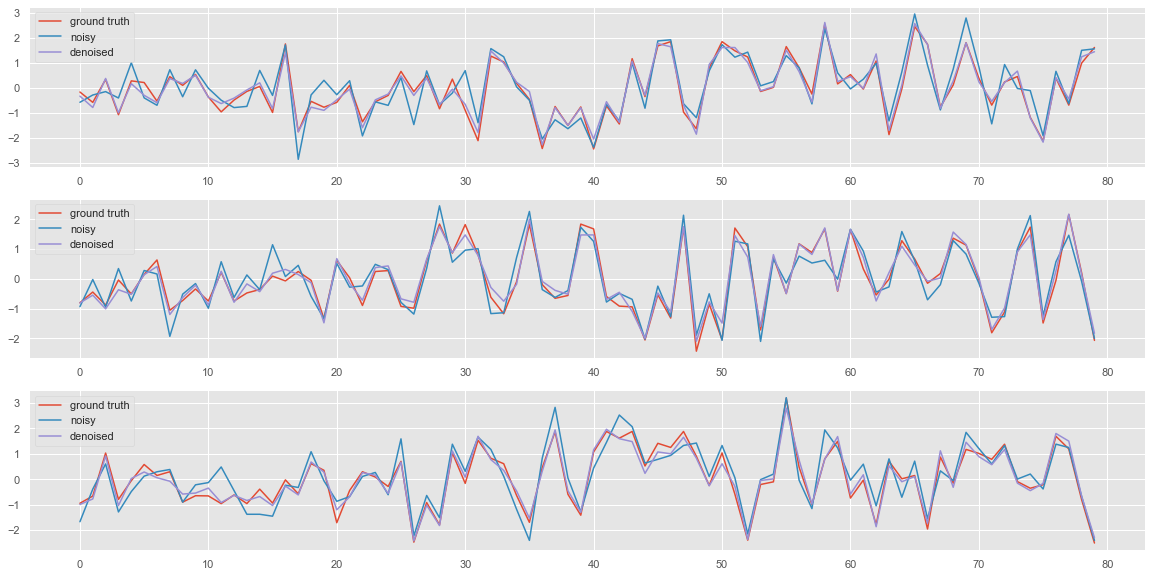

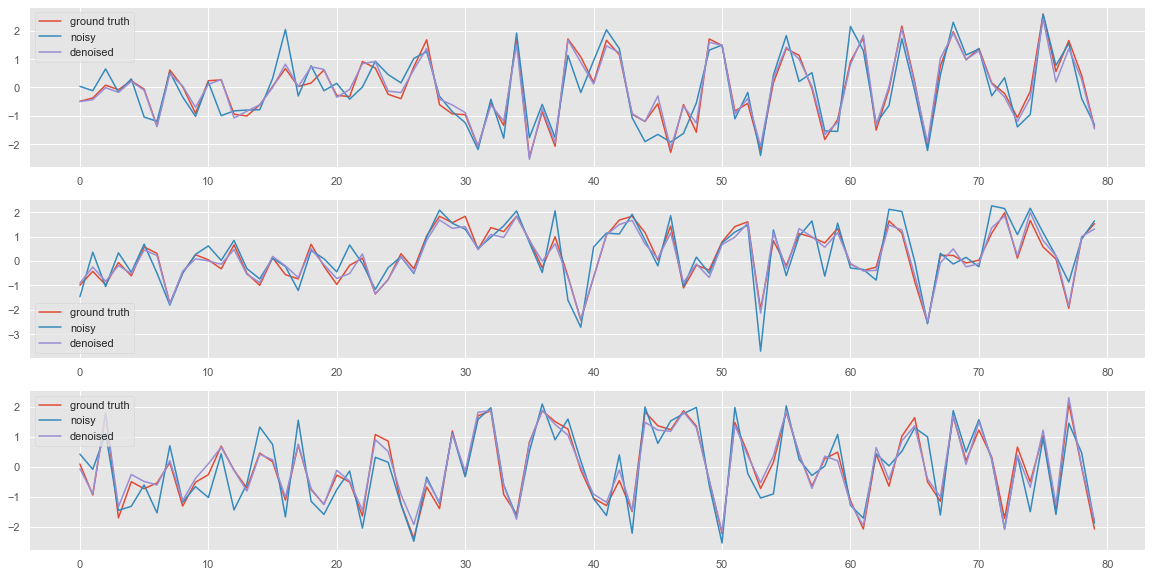

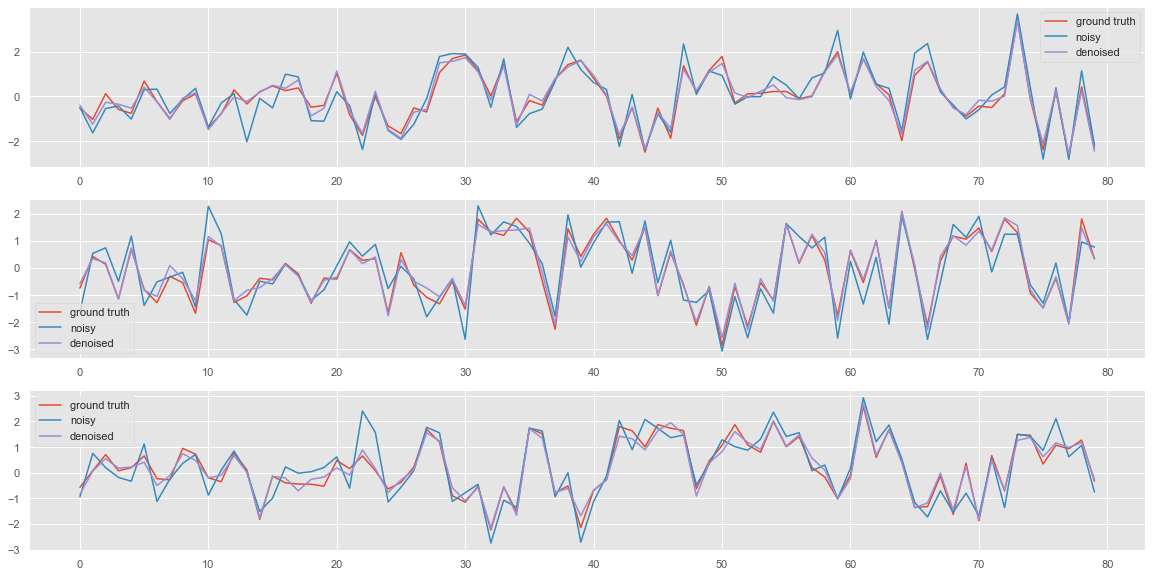

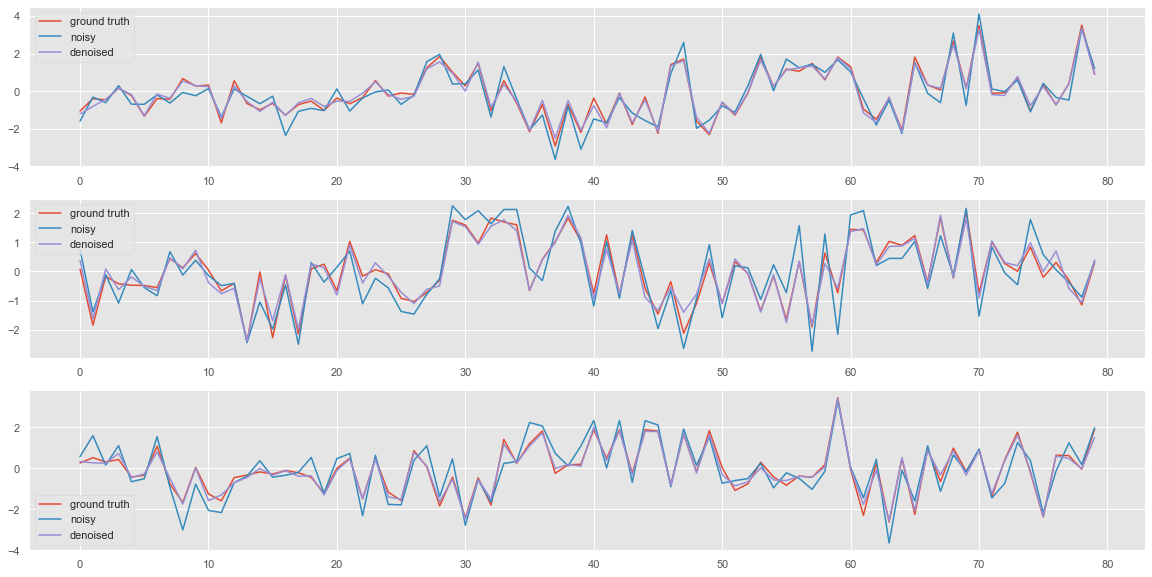

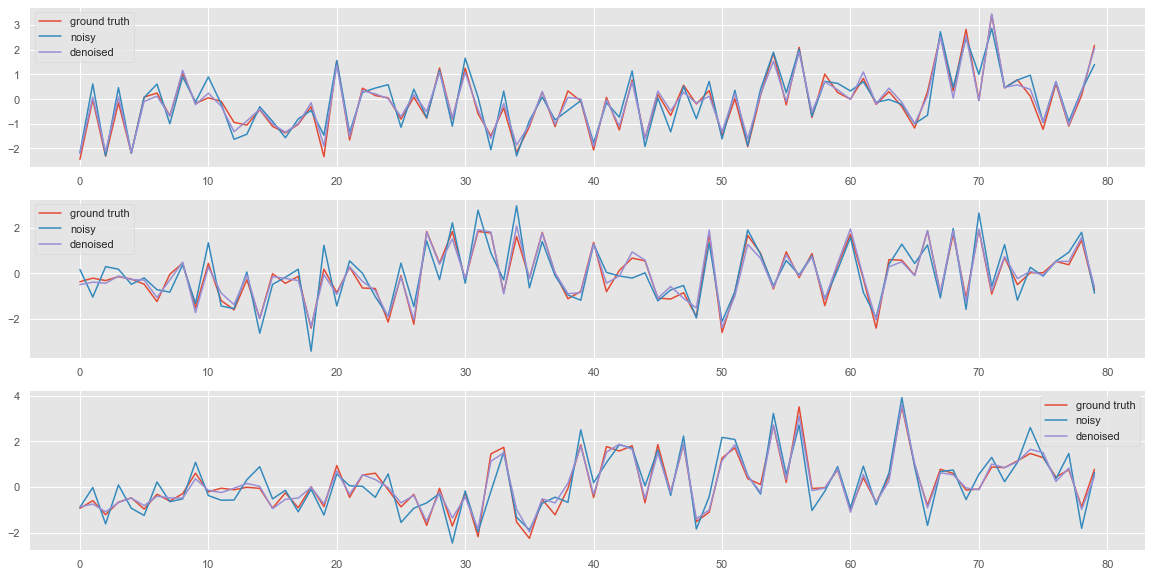

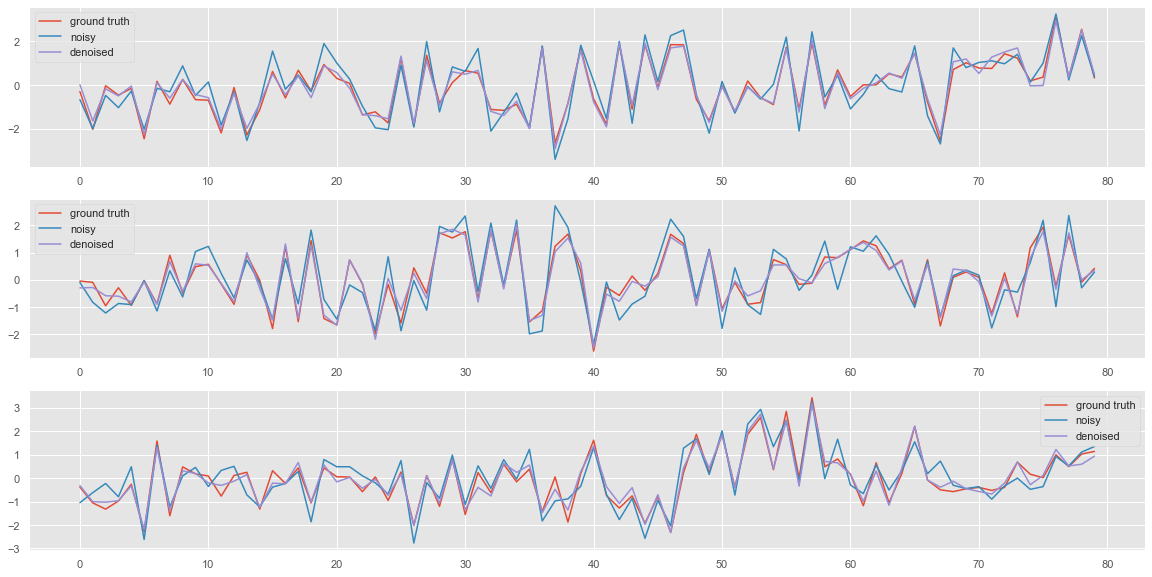

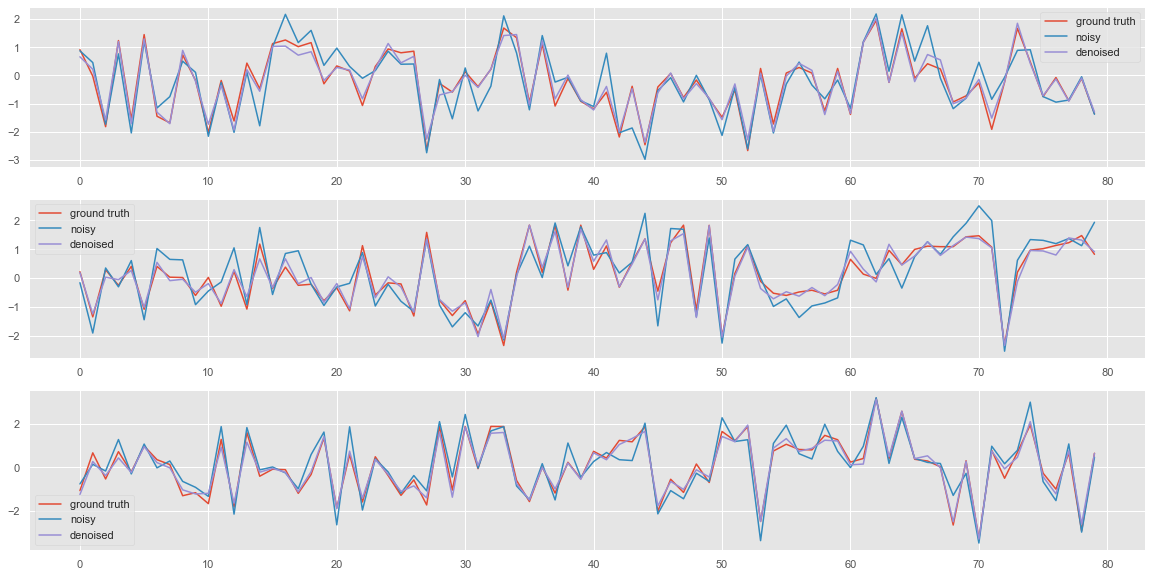

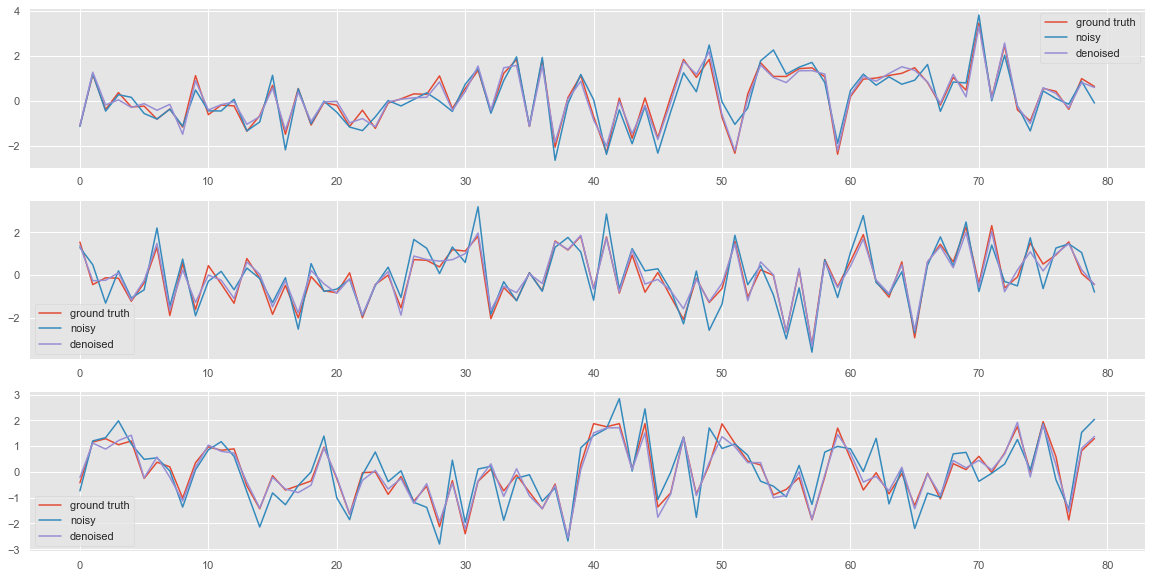

In [18]:
for i in range(10):
    plt.figure(figsize=(20, 10))
    plt.subplot(3, 1, 1)
    plt.plot(x_test[i, :, 0]*xsigma + xmu, label="ground truth")
    plt.plot(x_test_noise[i, :, 0]*xsigma + xmu, label="noisy")
    plt.plot(x_pred[i, :, 0]*xsigma + xmu, label="denoised")
    plt.legend()
    plt.subplot(3, 1, 2)
    plt.plot(x_test[i, :, 1]*ysigma + ymu, label="ground truth")
    plt.plot(x_test_noise[i, :, 1]*ysigma + ymu, label="noisy")
    plt.plot(x_pred[i, :, 1]*ysigma + ymu, label="denoised")
    plt.legend()
    plt.subplot(3, 1, 3)
    plt.plot(x_test[i, :, 2]*zsigma + zmu, label="ground truth")
    plt.plot(x_test_noise[i, :, 2]*zsigma + zmu, label="noisy")
    plt.plot(x_pred[i, :, 2]*zsigma + zmu, label="denoised")
    plt.legend()
    plt.show()